In [161]:
import pandas as pd
import numpy as np
import keras
from keras import layers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import tensorflow as tf
import phik
import seaborn as sns
import matplotlib.pyplot as plt

In [162]:
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
from ctgan import CTGAN
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.linear_model import RANSACRegressor
from collections import Counter
from imblearn.over_sampling import SMOTE, ADASYN
pd.set_option('display.float_format', '{:.2f}'.format)

<h1>Fixing the Regression</h1>


<b>Summary from the report</b>
<ul>
<li>Remove from the List</li>
<li>Cap the outliers, especially for the 6 focused on columns</li>
<li>Next Homework, fix distribution with synthetic Data for the ones where autovizviz, ydata and SHAP say the importance is higher (only for the kept columns, maybe redo all the reports with the cut down data)</li>
</ul>

In [163]:
df = pd.read_csv("Clean_Zillow.csv")
df.head()

,longitude,countyFIPS,monthlyHoaFee,annualHomeownersInsurance,state,yearBuilt,latitude,rentZestimate,city,zestimateLowPercent,...,bedrooms,price,zestimateHighPercent,homeType_APARTMENT,homeType_CONDO,homeType_LOT,homeType_MANUFACTURED,homeType_MULTI_FAMILY,homeType_SINGLE_FAMILY,homeType_TOWNHOUSE
0,-149.91,2020.00,0.00,2840,AK,1959.00,61.22,3142.00,Anchorage,12.00,...,3.00,676100,13.00,0,0,0,0,0,1,0
1,-149.91,2020.00,0.00,2934,AK,1961.00,61.22,3113.00,Anchorage,12.00,...,3.00,698600,13.00,0,0,0,0,0,1,0
2,-149.91,2020.00,0.00,4187,AK,1983.00,61.22,4282.00,Anchorage,12.00,...,4.00,996800,14.00,0,0,0,0,0,1,0
3,-149.91,2020.00,0.00,2920,AK,1947.00,61.22,3458.00,Anchorage,15.00,...,5.00,695300,16.00,0,0,0,0,0,1,0
4,-149.91,2020.00,0.00,4100,AK,2000.00,61.22,4161.00,Anchorage,18.00,...,4.00,976100,24.00,0,1,0,0,0,0,0


<b>Removing</b>

In [164]:
dropable=["state","city",'yearBuilt','zestimateLowPercent','zestimate','zestimateHighPercent','latitude','zipcode','timeOnZillow']
df=df.drop(dropable,axis=1)


X = df.drop(["price"], axis=1)
y = df['price']


<b>Combining</b>

In [165]:
#Chatgpt
# Example: Combine the sparse columns into an "Other" category
sparse_columns = ['homeType_LOT', 'homeType_MANUFACTURED', 'homeType_APARTMENT','homeType_TOWNHOUSE','homeType_MULTI_FAMILY']

# Create a new 'Other' column that combines the sparse categories
df['homeType_OTHER'] = df[sparse_columns].sum(axis=1)

# Drop the original sparse columns
df = df.drop(columns=sparse_columns)

# Check the updated DataFrame
df.head()

,longitude,countyFIPS,monthlyHoaFee,annualHomeownersInsurance,rentZestimate,livingArea,propertyTaxRate,bathrooms,bedrooms,price,homeType_CONDO,homeType_SINGLE_FAMILY,homeType_OTHER
0,-149.91,2020.00,0.00,2840,3142.00,2668.00,1.31,2.00,3.00,676100,0,1,0
1,-149.91,2020.00,0.00,2934,3113.00,3179.00,1.31,2.00,3.00,698600,0,1,0
2,-149.91,2020.00,0.00,4187,4282.00,3059.00,1.31,3.00,4.00,996800,0,1,0
3,-149.91,2020.00,0.00,2920,3458.00,1642.00,1.31,2.00,5.00,695300,0,1,0
4,-149.91,2020.00,0.00,4100,4161.00,4483.00,1.31,4.00,4.00,976100,1,0,0


<b>Cap/Outlier Removal</b>

<b>Distribution</b>

In [166]:
#Distribution of the Focused on variable
#Focused Variables are:
#rentZestimate, livingArea, propertyTaxRate, bathrooms, bedrooms, price

<b>Property Tax Rate</b>

In [167]:
target = "propertyTaxRate"

# typical X/y split, choose target variable as needed
X = df.drop([target], axis=1)
y = df[target]

ransac = RANSACRegressor(residual_threshold=np.std(y) * 1.5)
ransac.fit(X, y)

# now we have split the result into 
# inliers and outliers
# inliers => good data, follows the distribution nicely
# outliers => are far away from the main distribution
# the ~-sign (tilde) in pandas DataFrames means "the opposite of"
# so in this case => get everything from DataFrame EXCEPT the inliers
inlier_mask = ransac.inlier_mask_
outliers = df[~inlier_mask]
inliers = df[inlier_mask]

print(f"Inliers: {len(inliers)}")
print(f"Outliers: {len(outliers)}")


Inliers: 4881
Outliers: 62


<Axes: xlabel='propertyTaxRate', ylabel='Count'>

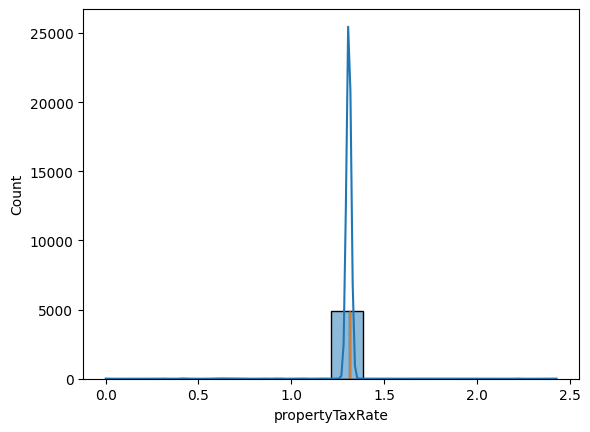

In [168]:
sns.histplot(data=df, x="propertyTaxRate", kde=True)

sns.histplot(data=inliers, x="propertyTaxRate", kde=False)

we cut down some of the data

<Axes: xlabel='propertyTaxRate', ylabel='Count'>

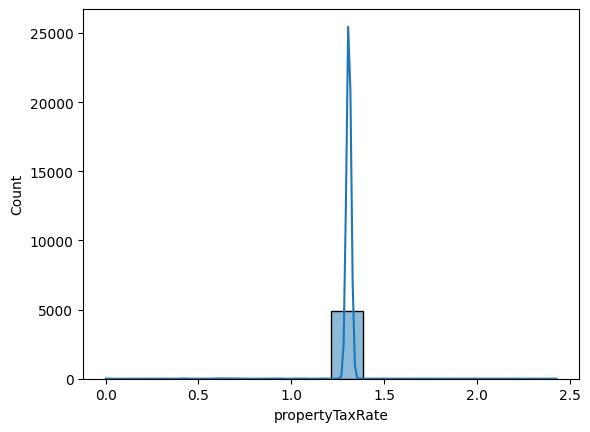

In [169]:
sns.histplot(data=df, x="propertyTaxRate", kde=True)

In [170]:
#we have 5k houses, so i will use SMOTE and then undersample
# after some consideration first undersampeling then ctgan is better
df.head()

,longitude,countyFIPS,monthlyHoaFee,annualHomeownersInsurance,rentZestimate,livingArea,propertyTaxRate,bathrooms,bedrooms,price,homeType_CONDO,homeType_SINGLE_FAMILY,homeType_OTHER
0,-149.91,2020.00,0.00,2840,3142.00,2668.00,1.31,2.00,3.00,676100,0,1,0
1,-149.91,2020.00,0.00,2934,3113.00,3179.00,1.31,2.00,3.00,698600,0,1,0
2,-149.91,2020.00,0.00,4187,4282.00,3059.00,1.31,3.00,4.00,996800,0,1,0
3,-149.91,2020.00,0.00,2920,3458.00,1642.00,1.31,2.00,5.00,695300,0,1,0
4,-149.91,2020.00,0.00,4100,4161.00,4483.00,1.31,4.00,4.00,976100,1,0,0


In [171]:
target = "propertyTaxRate"

# typical X/y split, choose target variable as needed
X = inliers.drop([target], axis=1)
y = inliers[target]

# initialize CTGAN and start training
# CTGAN is based on neural networks (GAN), that's why we have to specify epochs
ctgan = CTGAN()
ctgan.fit(df, epochs=100)

# get the data from the model
num_new_data = 10000
synthetic_df = ctgan.sample(num_new_data)


In [172]:
synthetic_df.describe()

,longitude,countyFIPS,monthlyHoaFee,annualHomeownersInsurance,rentZestimate,livingArea,propertyTaxRate,bathrooms,bedrooms,price,homeType_CONDO,homeType_SINGLE_FAMILY,homeType_OTHER
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,-148.84,2343.84,26.24,1554.07,2519.10,2024.42,1.30,2.19,3.17,350731.45,0.16,0.80,0.11
std,8.31,3190.12,93.81,688.48,794.49,958.52,0.09,0.85,0.98,149964.91,0.37,0.40,0.31
min,-150.20,1875.07,-86.86,-272.00,757.65,375.68,-0.36,-0.70,0.55,-47585.00,0.00,0.00,0.00
25%,-149.87,1996.22,-8.76,1087.00,1913.04,1371.48,1.31,1.57,2.95,254920.25,0.00,1.00,0.00
50%,-149.79,2023.20,-1.32,1481.50,2465.49,1904.41,1.31,2.01,2.99,343629.00,0.00,1.00,0.00
75%,-149.71,2050.88,7.09,1930.00,2982.78,2312.10,1.31,2.93,3.94,425757.25,0.00,1.00,0.00
max,-50.97,57173.09,1303.62,6012.00,6823.11,9455.17,2.45,6.60,9.75,1610368.00,1.00,1.00,1.00


In [173]:
# combine with original data
#df = pd.concat([df, synthetic_df])

<Axes: xlabel='propertyTaxRate', ylabel='Count'>

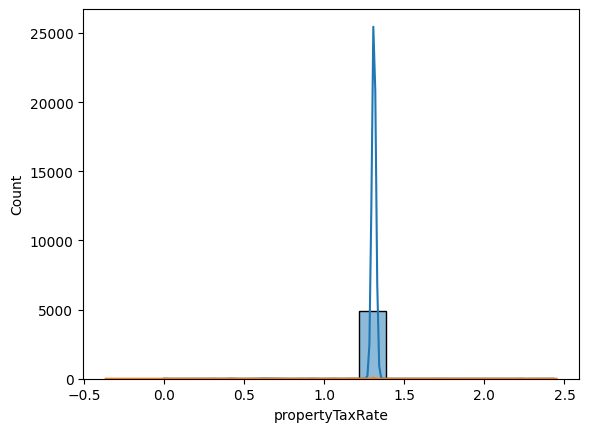

In [174]:
sns.histplot(data=df, x="propertyTaxRate", kde=True)

sns.histplot(data=synthetic_df, x="propertyTaxRate", kde=True)

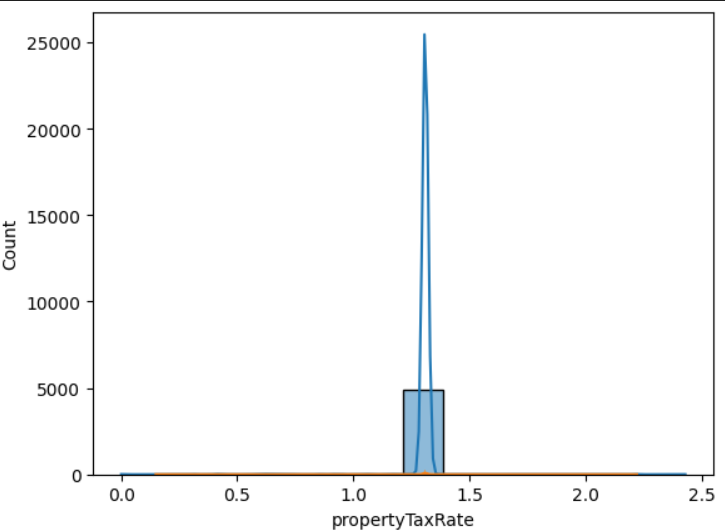

In [175]:
#cut off data
df.describe() - synthetic_df.describe()

,longitude,countyFIPS,monthlyHoaFee,annualHomeownersInsurance,rentZestimate,livingArea,propertyTaxRate,bathrooms,bedrooms,price,homeType_CONDO,homeType_SINGLE_FAMILY,homeType_OTHER
count,-5057.00,-5057.00,-5057.00,-5057.00,-5057.00,-5057.00,-5057.00,-5057.00,-5057.00,-5057.00,-5057.00,-5057.00,-5057.00
mean,-0.14,-28.19,31.43,127.24,128.29,-211.43,0.01,-0.09,0.04,49575.33,-0.01,-0.07,0.01
std,-0.69,-140.87,570.76,51.70,-61.23,-50.81,-0.02,0.13,0.27,26268.23,-0.01,0.05,0.01
min,0.19,-758.07,86.86,277.00,24.35,-374.68,0.36,0.70,-0.55,48835.00,0.00,0.00,0.00
25%,-0.06,23.78,8.76,158.00,263.46,-199.98,0.00,-0.07,0.05,41479.75,0.00,-1.00,0.00
50%,-0.08,-3.20,1.32,148.50,141.51,-188.41,0.00,-0.01,0.01,44571.00,0.00,0.00,0.00
75%,-0.11,-30.88,-7.09,42.00,32.22,-164.60,-0.00,-0.43,0.06,43792.75,0.00,0.00,0.00
max,-19.51,-2094.09,44625.38,5538.00,4720.89,5044.83,-0.02,23.40,20.25,1139632.00,0.00,0.00,0.00


Around half of the data is synthetic

In [176]:
target = "propertyTaxRate"

# typical X/y split, choose target variable as needed
X = synthetic_df.drop([target], axis=1)
y = synthetic_df[target]

ransac = RANSACRegressor(residual_threshold=np.std(y) * 1)
ransac.fit(X, y)

# now we have split the result into 
# inliers and outliers
# inliers => good data, follows the distribution nicely
# outliers => are far away from the main distribution
# the ~-sign (tilde) in pandas DataFrames means "the opposite of"
# so in this case => get everything from DataFrame EXCEPT the inliers
inlier_mask = ransac.inlier_mask_
outliers = synthetic_df[~inlier_mask]
inliers = synthetic_df[inlier_mask]

print(f"Inliers: {len(inliers)}")
print(f"Outliers: {len(outliers)}")


Inliers: 9560
Outliers: 440


<Axes: xlabel='propertyTaxRate', ylabel='Count'>

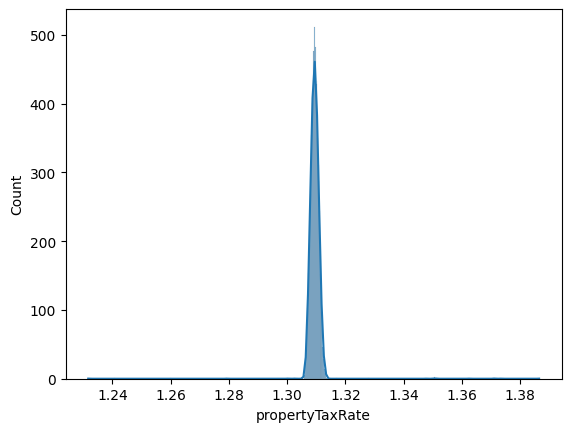

In [177]:
sns.histplot(data=inliers, x="propertyTaxRate", kde=True)

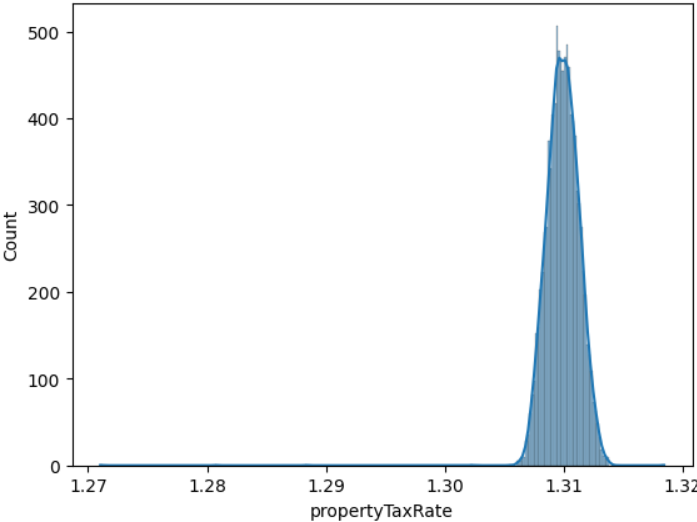

it actually looks good now ..... even tho the methodes to the mea are very questionable

<Axes: xlabel='propertyTaxRate', ylabel='Count'>

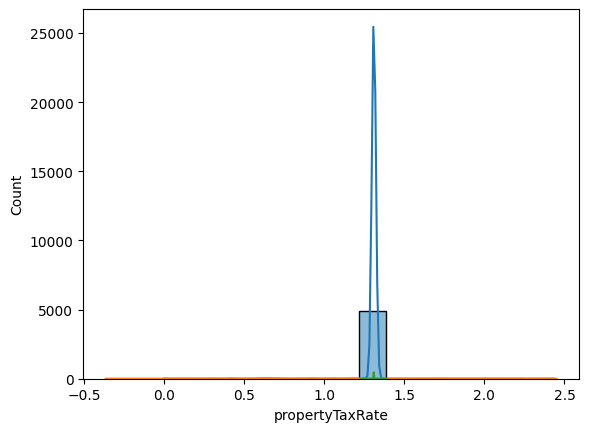

In [178]:
sns.histplot(data=df, x="propertyTaxRate", kde=True)

sns.histplot(data=synthetic_df, x="propertyTaxRate", kde=True)

sns.histplot(data=inliers, x="propertyTaxRate", kde=True)

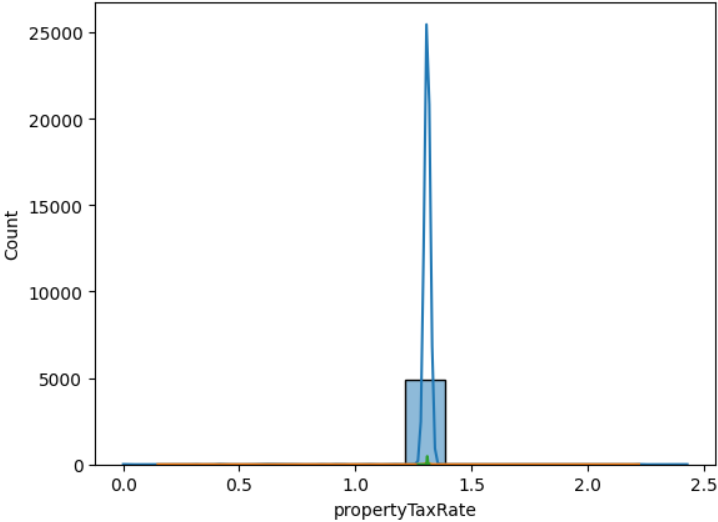

Okay soooo i did cut down the data with ranska, the ngenerated data with ctgan and then cut down with ranska agan, and now it looks actually acceptable

<b>Data Analytics</b>

In [179]:
# Round the bedrooms bathrooms to acceptable data type again
inliers.loc[:, 'bedrooms'] = inliers['bedrooms'].round().astype(int)
inliers.loc[:, 'bathrooms'] = (inliers['bathrooms'] * 2).round() / 2

In [180]:
inliers.describe()

,longitude,countyFIPS,monthlyHoaFee,annualHomeownersInsurance,rentZestimate,livingArea,propertyTaxRate,bathrooms,bedrooms,price,homeType_CONDO,homeType_SINGLE_FAMILY,homeType_OTHER
count,9560.00,9560.00,9560.00,9560.00,9560.00,9560.00,9560.00,9560.00,9560.00,9560.00,9560.00,9560.00,9560.00
mean,-149.79,2023.95,26.25,1554.16,2519.48,2022.17,1.31,2.20,3.20,350036.75,0.16,0.80,0.10
std,0.12,62.13,94.24,690.68,796.57,962.06,0.00,0.85,0.99,149597.34,0.37,0.40,0.31
min,-150.17,1875.07,-86.86,-272.00,757.65,375.68,1.23,-0.50,1.00,-47585.00,0.00,0.00,0.00
25%,-149.87,1996.09,-8.80,1084.00,1912.45,1367.96,1.31,1.50,3.00,254814.25,0.00,1.00,0.00
50%,-149.79,2022.74,-1.29,1481.00,2465.00,1900.84,1.31,2.00,3.00,343178.50,0.00,1.00,0.00
75%,-149.71,2049.88,7.07,1932.00,2984.00,2310.19,1.31,3.00,4.00,425082.75,0.00,1.00,0.00
max,-149.47,4549.92,1303.62,6012.00,6823.11,9455.17,1.39,6.50,10.00,1610368.00,1.00,1.00,1.00


In [181]:
df.describe()

,longitude,countyFIPS,monthlyHoaFee,annualHomeownersInsurance,rentZestimate,livingArea,propertyTaxRate,bathrooms,bedrooms,price,homeType_CONDO,homeType_SINGLE_FAMILY,homeType_OTHER
count,4943.00,4943.00,4943.00,4943.00,4943.00,4943.00,4943.00,4943.00,4943.00,4943.00,4943.00,4943.00,4943.00
mean,-148.98,2315.65,57.67,1681.31,2647.39,1812.99,1.31,2.10,3.21,400306.77,0.15,0.73,0.12
std,7.61,3049.25,664.56,740.18,733.26,907.71,0.07,0.98,1.25,176233.14,0.36,0.44,0.32
min,-150.01,1117.00,0.00,5.00,782.00,1.00,0.00,0.00,0.00,1250.00,0.00,0.00,0.00
25%,-149.93,2020.00,0.00,1245.00,2176.50,1171.50,1.31,1.50,3.00,296400.00,0.00,0.00,0.00
50%,-149.87,2020.00,0.00,1630.00,2607.00,1716.00,1.31,2.00,3.00,388200.00,0.00,1.00,0.00
75%,-149.81,2020.00,0.00,1972.00,3015.00,2147.50,1.31,2.50,4.00,469550.00,0.00,1.00,0.00
max,-70.48,55079.00,45929.00,11550.00,11544.00,14500.00,2.43,30.00,30.00,2750000.00,1.00,1.00,1.00


In [182]:
df.describe() - inliers.describe()
#rentZestimate, livingArea, propertyTaxRate, bathrooms, bedrooms, price

,longitude,countyFIPS,monthlyHoaFee,annualHomeownersInsurance,rentZestimate,livingArea,propertyTaxRate,bathrooms,bedrooms,price,homeType_CONDO,homeType_SINGLE_FAMILY,homeType_OTHER
count,-4617.00,-4617.00,-4617.00,-4617.00,-4617.00,-4617.00,-4617.00,-4617.00,-4617.00,-4617.00,-4617.00,-4617.00,-4617.00
mean,0.82,291.70,31.43,127.15,127.91,-209.18,-0.00,-0.10,0.00,50270.02,-0.01,-0.07,0.01
std,7.50,2987.13,570.32,49.50,-63.31,-54.35,0.07,0.13,0.26,26635.80,-0.01,0.05,0.02
min,0.16,-758.07,86.86,277.00,24.35,-374.68,-1.23,0.50,-1.00,48835.00,0.00,0.00,0.00
25%,-0.05,23.91,8.80,161.00,264.05,-196.46,0.00,0.00,0.00,41585.75,0.00,-1.00,0.00
50%,-0.08,-2.74,1.29,149.00,142.00,-184.84,0.00,0.00,0.00,45021.50,0.00,0.00,0.00
75%,-0.10,-29.88,-7.07,40.00,31.00,-162.69,-0.00,-0.50,0.00,44467.25,0.00,0.00,0.00
max,78.98,50529.08,44625.38,5538.00,4720.89,5044.83,1.04,23.50,20.00,1139632.00,0.00,0.00,0.00


<ul>
<li>Property tax rate
<ul>longitude
<li>std: 7.50 is a huge change, before it was 7.8 now its 0.3, this means that longitude has changed a lot ? lets check below,will need to be cut down</li></ul></li>
<ul>countFIPS
<li>std: 3015.22 is again all of its deviation, looking at te plots the distribution now looks way better</li></ul></li>
<ul>rentZestimate
<li>no meaningfull changes</li></ul></li>
<ul>livingArea
<li>no meaningfull changes</li></ul></li>
<ul>Bathrooms and Bedrooms
<li>no meaningfull changes</li></ul></li>
<ul>Price:
<li>Mean: -50k wich is around 12% less</li>
<li>Std: -20k wich is aroudn 13%</li></ul></li>
</ul>

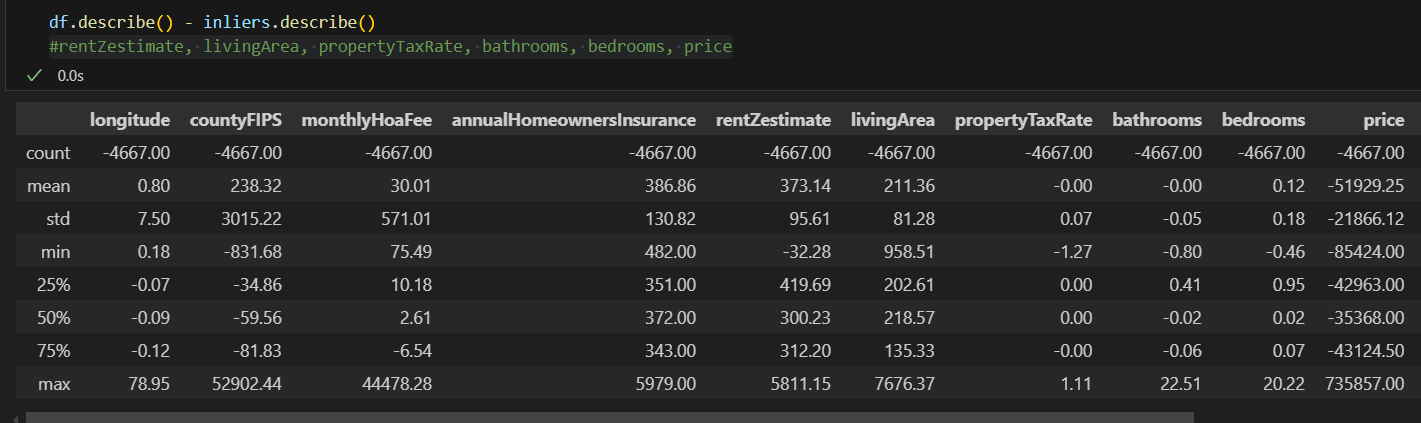

<Axes: xlabel='longitude', ylabel='Count'>

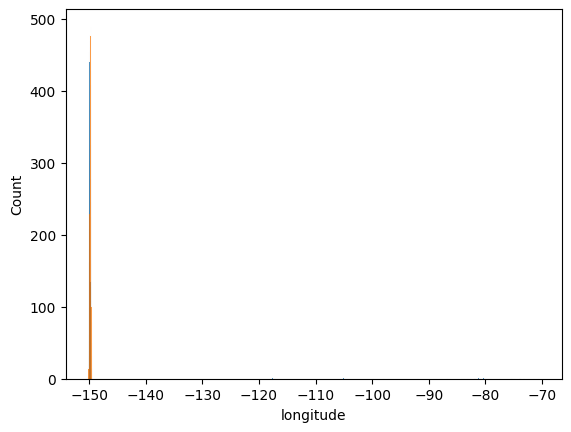

In [183]:
sns.histplot(data=df, x="longitude", kde=False)

sns.histplot(data=inliers, x="longitude", kde=False)

<Axes: xlabel='countyFIPS', ylabel='Count'>

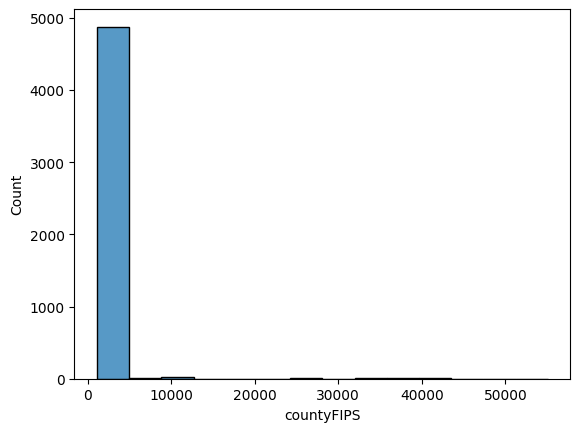

In [184]:

sns.histplot(data=df, x="countyFIPS", kde=False)

<Axes: xlabel='countyFIPS', ylabel='Count'>

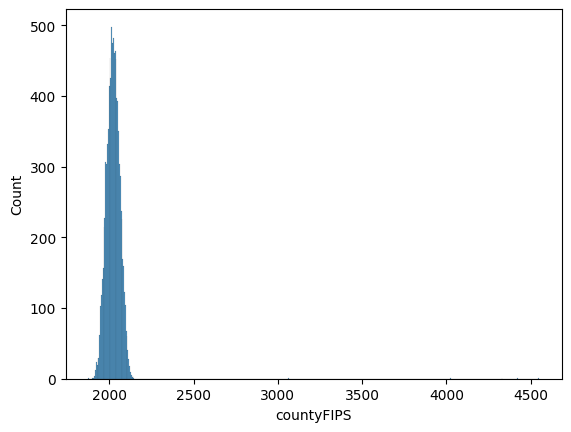

In [185]:
sns.histplot(data=inliers, x="countyFIPS", kde=False)

<b>SEARCH FOR THE NEXT ONE TO WORK ON</b>

<Axes: xlabel='bedrooms', ylabel='Count'>

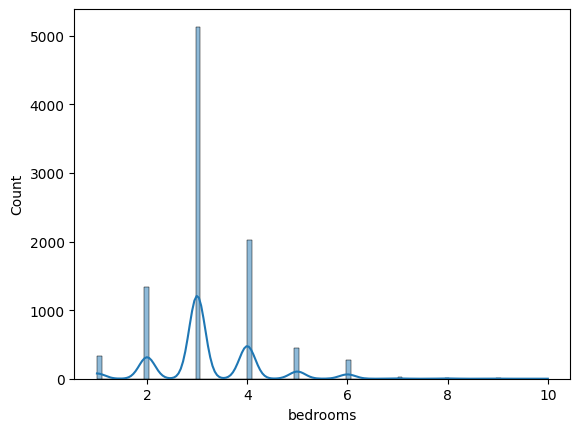

In [186]:
#rentZestimate, livingArea, propertyTaxRate, bathrooms, bedrooms, price
#go through every distribution
sns.histplot(data=inliers, x="bedrooms", kde=True)

#at the screenshot below i did not fix the Int yet, so there where half bedrooms xD

<b>Bedrooms</b>

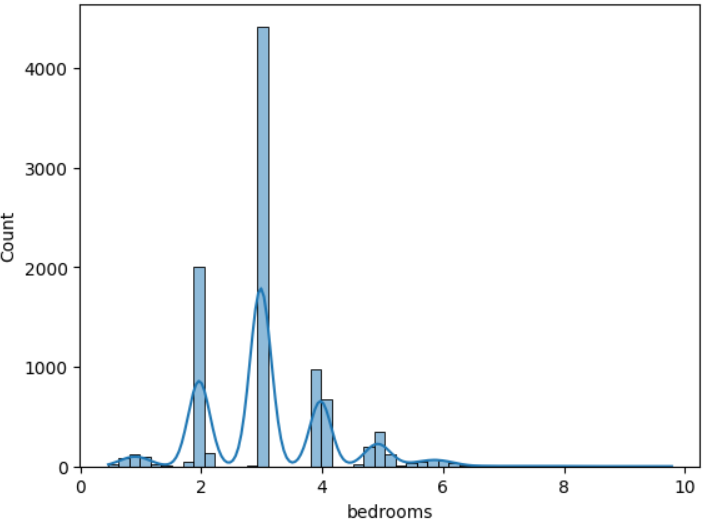

In [187]:
inliers['bedrooms'].value_counts().sort_index()

bedrooms
1.00      325
2.00     1331
3.00     5134
4.00     2019
5.00      443
6.00      266
7.00       18
8.00       17
9.00        6
10.00       1
Name: count, dtype: int64

In [188]:
inliers['bedrooms']=inliers['bedrooms'].replace({9:8})
inliers['bedrooms']=inliers['bedrooms'].replace({8:7})
inliers['bedrooms']=inliers['bedrooms'].replace({7:6})
inliers['bedrooms']=inliers['bedrooms'].replace({0:1})

C:\Users\janni\AppData\Local\Temp\ipykernel_36488\1577843608.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inliers['bedrooms']=inliers['bedrooms'].replace({9:8})
C:\Users\janni\AppData\Local\Temp\ipykernel_36488\1577843608.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inliers['bedrooms']=inliers['bedrooms'].replace({8:7})
C:\Users\janni\AppData\Local\Temp\ipykernel_36488\1577843608.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

bedrooms
3.00     5134
4.00     2019
2.00     1331
5.00      443
1.00      325
6.00      307
10.00       1
Name: count, dtype: int64


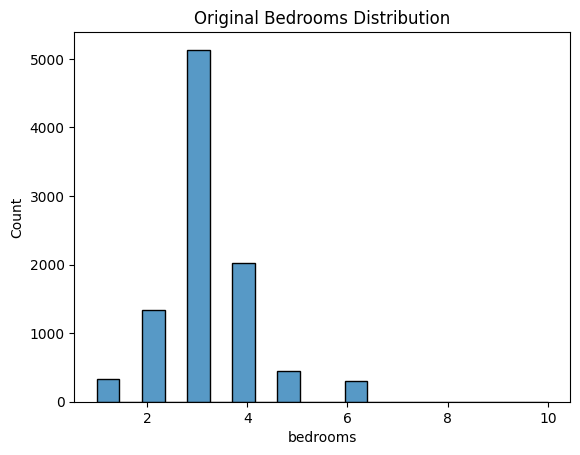

In [189]:
import seaborn as sns

# Check the current distribution
sns.histplot(data=inliers, x="bedrooms", kde=False, bins=20)
plt.title("Original Bedrooms Distribution")

# Inspect value counts
print(inliers['bedrooms'].value_counts())

<b>DISTRIBUTION IS NORMALISH</b>
No generation is needed (i would have to ad the lowest generate around 1,5 times more data, and after having already around 50% of the data beeing generated, the split would be too strong)

In [190]:
#target = "bedrooms"

#X = inliers.drop([target], axis=1)
#y = inliers[target]

#strategy = {1:5000 ,2:5500 ,3:4550 ,4:6000 ,5:5500 ,6:5000}

#model = SMOTE(sampling_strategy=strategy, random_state=42)

# model = ADASYN(sampling_strategy="auto", random_state=42)

#X_resampled, y_resampled = model.fit_resample(X, y)

#df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
#f_resampled[target] = y_resampled

In [191]:
# combine dataframes, now we have the original data + newly generated data
#df = pd.concat([inliers, df_resampled])

In [192]:
#df_resampled.describe()

<Axes: xlabel='bedrooms', ylabel='Count'>

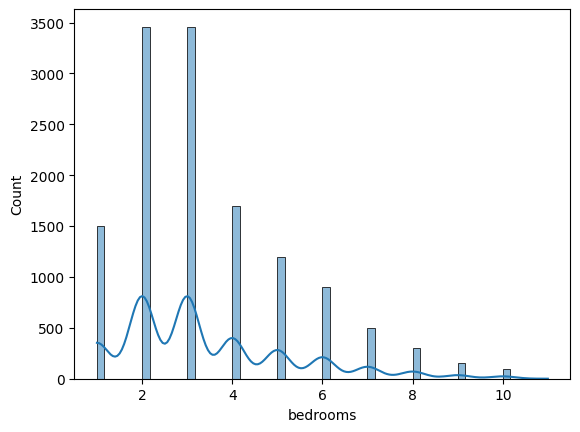

In [193]:
sns.histplot(data=df_resampled, x="bedrooms", kde=True)

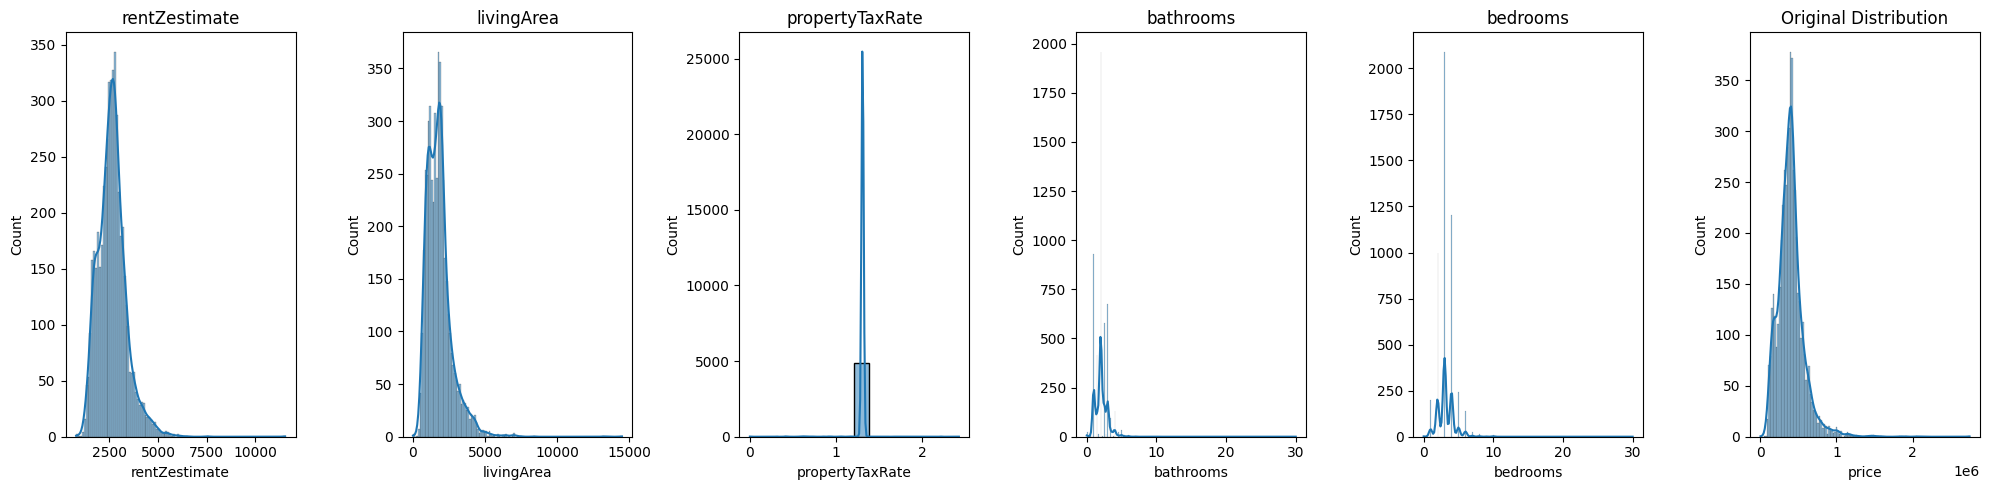

In [194]:
# Define the variables to plot
variables = ['rentZestimate', 'livingArea', 'propertyTaxRate', 'bathrooms', 'bedrooms', 'price']

# Create a figure with subplots for each variable
fig, axes = plt.subplots(nrows=1, ncols=len(variables), figsize=(20, 5), sharey=False)

# Iterate over variables and create a plot for each
for ax, var in zip(axes, variables):
    sns.histplot(data=df, x=var, kde=True, ax=ax)  # Create histogram with KDE
    ax.set_title(var)  # Set title for each subplot
    ax.set_xlabel(var)  # Set x-label
    ax.set_ylabel("Count")  # Set y-label

# Adjust layout for better appearance
plt.tight_layout()
plt.title("Original Distribution")

# Show the final plot
plt.show()


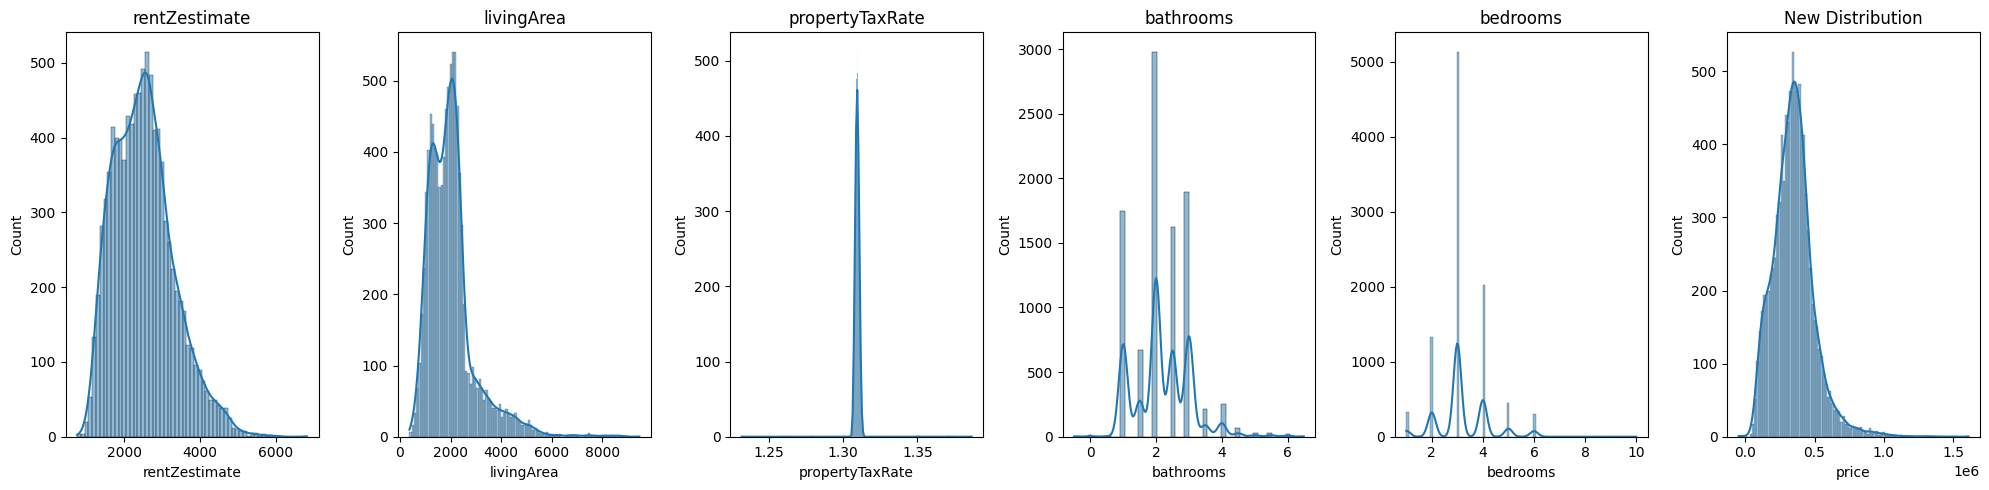

In [195]:
# Define the variables to plot
variables = ['rentZestimate', 'livingArea', 'propertyTaxRate', 'bathrooms', 'bedrooms', 'price']

# Create a figure with subplots for each variable
fig, axes = plt.subplots(nrows=1, ncols=len(variables), figsize=(20, 5), sharey=False)

# Iterate over variables and create a plot for each
for ax, var in zip(axes, variables):
    sns.histplot(data=inliers, x=var, kde=True, ax=ax)  # Create histogram with KDE
    ax.set_title(var)  # Set title for each subplot
    ax.set_xlabel(var)  # Set x-label
    ax.set_ylabel("Count")  # Set y-label

# Adjust layout for better appearance
plt.tight_layout()
plt.title("New Distribution")

# Show the final plot
plt.show()


All Distributions have been widened a bit by the generated Data, half of the Data is Synthetic, this shows, overall i am around 60 % happy with this and would have liked if i could have generated data evenmore towards the normal distribution.

In [201]:
df = inliers.copy()

<b>Finished Product</b>


In [202]:
df.to_csv('fixed_Zillow.csv', index=False)